## Project 3 - Manifold Learning in the context of Partially Labelled Classification
by Telmo Cunha - 21/06/2022

## Table of contents
1. [Libraries & Data Import](#1)
2. [PCA](#2)
3. [Adjacency Matrix & Laplace Operator](#3)
4. [Selecting a random labeled dataset](#4)
5. [Eigenvalues/Eigenvectors of the Graph Laplacian](#5)
6. [Classification function, predicted labels and error rate](#6)
7. [Results using 60,000 datapoints](#7)
8. [Results using 10,000 datapoints](#8)
9. [Results using 1,000 datapoints](#9)
10. [Results using kNN](#10)
11. [Final Plot](#11)

## 1. Libraries & Data Import <a name="1"></a>

Importing the MNIST dataset and required libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.decomposition import PCA

# install library command (in conda): pip install python-mnist
from mnist import MNIST
from sklearn.neighbors import kneighbors_graph
import scipy.sparse as sp
import scipy.sparse.linalg  as la

In [2]:
mnistdata = MNIST('data')

# image_features contains 60,000 images of digits where each image_features[i] is a 28*28=784 sized vector with entries
# corresponding to gray scale factors from {0,1,...,255}
image_features, labels = mnistdata.load_training()

In [3]:
# Random example from the dataset

# Select a random datapoint
index = random.randrange(0, len(image_features))

# Print the 'picture'
print("Picture:",mnistdata.display(image_features[index]))

# Print the label
print("\nLabel:")
print(labels[index])

# Print the 28x28=784 vector
print("\nVector:")
print(image_features[index])

Picture: 
............................
............................
............................
............................
............................
............................
............................
.........@@@.....@@@@@......
.........@@@@@@@@@@@@@......
........@@@@@.....@@@@......
........@@@.......@@@@......
........@@........@@@.......
.................@@@@.......
.................@@@........
................@@@.........
...............@@@@.........
..............@@@@..........
..............@@@...........
.............@@@............
............@@@@............
............@@@.............
...........@@@..............
..........@@@...............
.........@@@................
........@@@@................
........@@@.................
........@...................
............................

Label:
7

Vector:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## 2. PCA <a name="2"></a>

To reduce computation time and because some pixels in the image are not significant we first perform PCA to reduce dimensionality. Since all values are within the same range, $\{0,1,...,255\}$, we do not standardize the data. We mimick the main paper and keep 100 principal components.

In [4]:
pca = PCA(n_components = 100)
pca_features = pca.fit_transform(image_features)

## 3. Adjacency Matrix & Laplace Operator <a name="3"></a>

To compute the adjacency matrix $W$ over the entire dataset we use the $\textbf{kneighbors_graph()}$ function from sklearn. This function returns a compressed sparse row (csr) matrix, $A$, with the $k$ nearest neighbours for each node, i.e. each datapoint.

This will not be the adjacency matrix $W$, if node $i$ has $k$ neighbours, one of each is node $j$ but node $j$ has $k$ neighbours which does not include node $i$ then $A_{ij}=1$ and $A_{ji}=0$ where we would want both to be 1. Therefore we need to symmetrize the matrix, we construct $W=A+A^T$ and then do $W[W>=1]=1$ to convert the entries that become 2 to 1 to finally obtain the adjacency matrix.

In order to compute the (Graph) Laplace operator, $L=D-W$, we need to determine the diagonal matrix $D$. Since $D_{ii}=deg(node_i)$ we just take the sum over each row (or column).

In [5]:
def graph_laplacian(pca_features):
    
    # k sets the number of neighbours to consider
    k=8
    
    # Returns a compressed sparse row (csr) matrix type
    A = kneighbors_graph(pca_features, n_neighbors=k, mode='connectivity', metric='minkowski', p=2, include_self=False)
    W=(A+A.T)
    W[W>=1]=1
    
    X=W.sum(axis = 1)
    
    A=np.asarray(X)
    a=[]
    for i in range(len(A)):
        a.append(A[i][0])
        
    D=sp.diags(a, offsets=0, shape=None, format=None, dtype=None)
    L=D-W
    
    return L

In [6]:
L = graph_laplacian(pca_features)

## 4. Selecting a random labeled dataset <a name="4"></a>

To build a labeled dataset of size $s$ we just copy $s$ randomly chosen datapoints and labels from the original dataset. Recall that these are the only labels that we shall consider under this semi-supervised learning model. Therefore, the remaining dataset (minus these chosen datapoints) will be unlabeled.

In [7]:
def sample_label_points(s,image_features,labels):
    # list of all possible datapoint indices
    all_indices=np.arange(len(image_features))
    
    # list of a random choice of indices to remove from the data
    index_list=np.random.choice(all_indices,s,replace='false')
    index_list=np.sort(index_list)
    
    # constructing the labeled dataset
    labeled_images_dataset=[]
    labeled_labels_dataset=[]
    
    for i in index_list:
        labeled_images_dataset.append(image_features[i])
        labeled_labels_dataset.append(labels[i])
        
    return labeled_images_dataset, labeled_labels_dataset, index_list

In [8]:
# number of labeled points
s=100
labeled_images_dataset, labels_labeled_dataset, index_list = sample_label_points(s,image_features,labels)

## 5. Eigenvalues/Eigenvectors of the Graph Laplacian <a name="5"></a>

Here we compute the eigenfunctions of the graph Laplacian where the number of eigenfunctions we keep (for smoothness purposes) is $20\%$ of the size of the labeled dataset (as done in the paper). The solution of the least squares optimization problem is given by $(E^TE)^{-1}E^Tc$. We compute $E$ using the $\textit{E_matrix()}$ function and $c$ using the $\textit{c_vector()}$ function.

In [9]:
# p = number of eigenvectors to consider for smoothness purposes (p=20% of the labeled set size)
p=round(s*0.2)

# selecting the smallest magnitude eigenvalues and eigenvectors 
evalues, efunctions=la.eigs(L,k=p,which='SM')

In [10]:
# constructing the E matrix (solution of the optimization problem is )

def E_matrix(efunctions,index_list,s,p):

    E=np.zeros((s,p))
    
    for i in range(s):
        for j in range(p):
            
            # we need to retrieve the entry correspoding to the datapoint coming from index_list
            # this is the jth eigenvector, evector[:][j], with entry i corresponding to labeled points
            E[i][j]=efunctions[index_list[i]][j]
            
    return E

In [11]:
# constructs the one-against all c vector of size s for a certain digit

def c_vector(digit,labels_labeled_dataset):
    
    c=np.zeros((len(labels_labeled_dataset),1))
    
    for i in range(len(labels_labeled_dataset)):
        if(labels_labeled_dataset[i]==digit):
            c[i]=1
        else:
            c[i]=-1    
    return c

In [12]:
# calculations to obtain the solution of the optimization problem

E=E_matrix(efunctions,index_list,s,p)
X=np.matmul(E.T,E)
Y=np.linalg.inv(X)
Z=np.matmul(Y,E.T)

C:\Users\telmo\AppData\Local\Temp\ipykernel_20336\2120893750.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i][j]=efunctions[index_list[i]][j]


## 6. Classification function, predicted labels and error rate <a name="6"></a>

We shall use a one-against-all classification approach where we build a classifier for each class, i.e. each digit, and then use the result on each class as a confidence level on the predicted label.

In [13]:
# computes the coefficients over the basis of eigenfunctions of L for each digit
    
def classifier_coefs(digit,labels_labeled_dataset):
    
    c=c_vector(digit,labels_labeled_dataset)
    a=np.dot(Z,c)
    
    return a

In [14]:
# computes the classification results for each classifier and stores them on a matrix over the entire dataset (60000)
# over each digit (10)

def confidence_measure(efunctions,labels_labeled_dataset,n = 60000):
    
    confidence_levels=np.zeros((60000,10))
    
    for digit in range(10):
        
        # c is the one against all label vector
        a=classifier_coefs(digit,labels_labeled_dataset)
        
        for i in range(n):
            
            y=np.real(efunctions[i][:].reshape((p,1)))
            c_i=np.dot(a.T,y)
            c_i=round(c_i[0][0],3)
                    
            confidence_levels[i][digit]=c_i
    
    return confidence_levels

In [15]:
# using the confidence_levels matrix we compute the labels by picking the class with highest confidence value

def computing_labels(confidence_levels,n):
    
    final_labels=[]
    
    for i in range(n):
        
        l=confidence_levels[i,:]
        x=np.argmax(l)
        
        #print("l:",l,"argmax:",x)
        
        final_labels.append(x)
            
    return final_labels

In [16]:
# the warning is not an issue, since the matrix is symmetric we know all eigenvalues are real
confidence_levels = confidence_measure(efunctions,labels_labeled_dataset)

In [17]:
final_labels = computing_labels(confidence_levels,60000)

In [18]:
# we compute the error rate by considering false positives and false negatives over the unlabeled dataset

def error_rate(labels,final_labels):
    
    error_count=0
    
    for i in range(len(labels)):
        
        if not(i in index_list):
            
            if(labels[i] != final_labels[i]):
                error_count+=1.0
                
    error_rate=error_count/(len(labels)-len(index_list))
    
    return round(100*error_rate,3)

In [19]:
e=error_rate(labels,final_labels)
print("Error rate for s =", s, ":", e, "%")

Error rate for s = 100 : 7.711 %


## 7. Results using 60,000 datapoints <a name="7"></a>

Having explained the procedure we now check the results by considering $10$ trials, i.e. we average the results over $10$ random draws of the labeled dataset, for different values of $s$, i.e. the size of the labeled dataset. For $s\geq 5000$ we consider only 3 trials due to the time it takes to run.

In [20]:
trials=10
errors_trials=np.zeros((trials,1))

# with s=5000 onwards it gets super slow so we do only 3 trials
s_list=[20,50,100,500,1000,5000]
#s_list=[20,50,100,500,1000,5000,20000]
#takes a long long time to run

error60000_s={}

for s in s_list:
    
    if(s>=5000):
        trials=3

    for k in range(trials):
        
        print("Run:", k+1, "; s:",s)
        
        # i=s: number of labeled examples
        labeled_images_dataset, labels_labeled_dataset, index_list=sample_label_points(s,image_features,labels)
        
        # p: number of eigenfunctions to keep
        p=round(s*0.2)
        
        # computes the lowest eigenvalues/eigenvectors of the Laplace operator
        evalues, efunctions=la.eigs(L,k=p,which='SM')
        
        E=E_matrix(efunctions,index_list,s,p)
        X=np.matmul(E.T,E)
        Y=np.linalg.inv(X)
        Z=np.matmul(Y,E.T)
        
        # compute the labels for unlabeled points
        confidence_levels = confidence_measure(efunctions,labels_labeled_dataset)
        final_labels = computing_labels(confidence_levels,60000)
        
        # compute the error rate
        errors_trials[k]=error_rate(labels,final_labels)
        
    x=round(np.mean(errors_trials),3)
    print("s=",s,"error:",x,"%")   
    error60000_s[s]=x

Run: 1 ; s: 20


C:\Users\telmo\AppData\Local\Temp\ipykernel_20336\2120893750.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i][j]=efunctions[index_list[i]][j]


Run: 2 ; s: 20
Run: 3 ; s: 20
Run: 4 ; s: 20
Run: 5 ; s: 20
Run: 6 ; s: 20
Run: 7 ; s: 20
Run: 8 ; s: 20
Run: 9 ; s: 20
Run: 10 ; s: 20
s= 20 error: 58.194 %
Run: 1 ; s: 50
Run: 2 ; s: 50
Run: 3 ; s: 50
Run: 4 ; s: 50
Run: 5 ; s: 50
Run: 6 ; s: 50
Run: 7 ; s: 50
Run: 8 ; s: 50
Run: 9 ; s: 50
Run: 10 ; s: 50
s= 50 error: 25.159 %
Run: 1 ; s: 100
Run: 2 ; s: 100
Run: 3 ; s: 100
Run: 4 ; s: 100
Run: 5 ; s: 100
Run: 6 ; s: 100
Run: 7 ; s: 100
Run: 8 ; s: 100
Run: 9 ; s: 100
Run: 10 ; s: 100
s= 100 error: 8.022 %
Run: 1 ; s: 500
Run: 2 ; s: 500
Run: 3 ; s: 500
Run: 4 ; s: 500
Run: 5 ; s: 500
Run: 6 ; s: 500
Run: 7 ; s: 500
Run: 8 ; s: 500
Run: 9 ; s: 500
Run: 10 ; s: 500
s= 500 error: 4.089 %
Run: 1 ; s: 1000
Run: 2 ; s: 1000
Run: 3 ; s: 1000
Run: 4 ; s: 1000
Run: 5 ; s: 1000
Run: 6 ; s: 1000
Run: 7 ; s: 1000
Run: 8 ; s: 1000
Run: 9 ; s: 1000
Run: 10 ; s: 1000
s= 1000 error: 3.635 %
Run: 1 ; s: 5000
Run: 2 ; s: 5000
Run: 3 ; s: 5000
s= 5000 error: 3.431 %


Text(0.5, 1.0, 'Error rate for 60000 datapoints (# of labeled examples)')

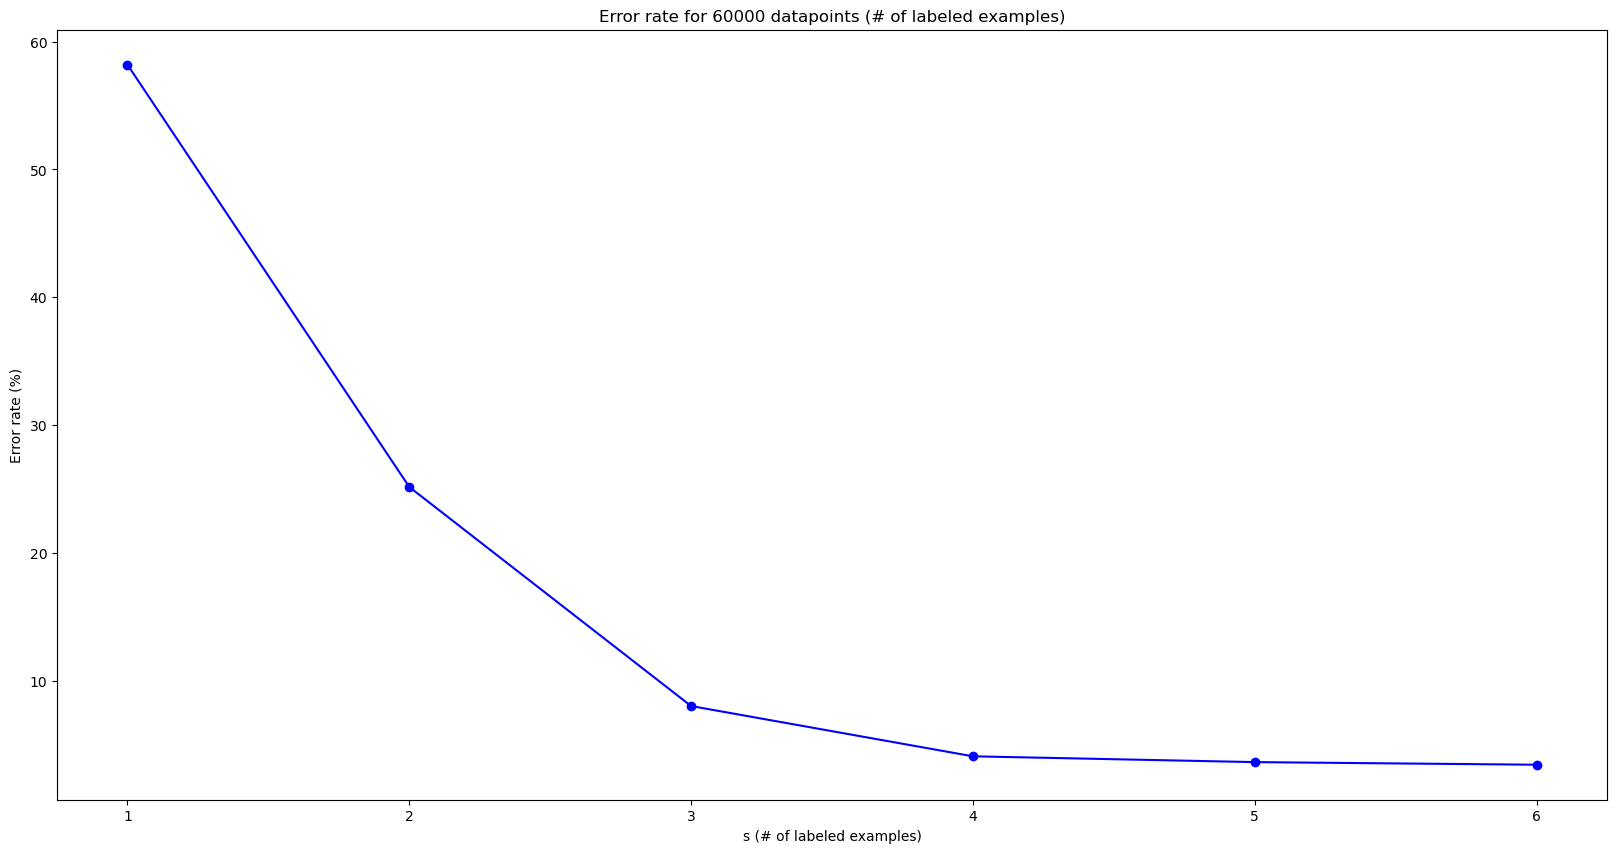

In [21]:
#plot specifications

# since the x axis distance is not relevant we use the code [1-20,2-50,3-100,4-500,5-1000,6-5000,7-20000]
#x=list(error60000_s.keys())
x=[1,2,3,4,5,6]

y=list(error60000_s.values())
plt.figure(figsize=(20, 10))
plt.plot(x, y, marker='o', color='b')
plt.xticks([1,2,3,4,5,6])
plt.xlabel('s (# of labeled examples)')  # Add an x-label to the axes.
#plt.xticks(np.arange(min(x)-1, 610, 20.0))
plt.ylabel('Error rate (%)')  # Add a y-label to the axes.
plt.title("Error rate for 60000 datapoints (# of labeled examples)")  # Add a title to the axes.

## 8. Results using 10,000 datapoints <a name="8"></a>

We do an example first, since there's an extra step now. First we draw 10000 datapoints of the 60000 dataset and further select the labeled dataset out of the 10000 dataset. Procedure for one trial with $s=100$:

In [22]:
# n: number of datapoints to consider for manifold learning
n=10000

# construct dataset of size n
features_dataset, labels_dataset, not_needed = sample_label_points(n,image_features,labels)

# performing pca on the dataset
pca = PCA(n_components = 100)
pca_features = pca.fit_transform(features_dataset)

In [23]:
L=graph_laplacian(pca_features)

In [24]:
# s: size of labeled dataset
s=100

# construct labeled dataset of size s
features_labeled_dataset, labels_labeled_dataset, index_list = sample_label_points(s,pca_features,labels_dataset)

In [25]:
# p: number of eigenfunctions to consider
p=round(s*0.2)
evalues, efunctions=la.eigs(L,k=p,which='SM')

E=E_matrix(efunctions,index_list,s,p)
X=np.matmul(E.T,E)
Y=np.linalg.inv(X)
Z=np.matmul(Y,E.T)

# We can ignore 'ComplexWarning', since the matrix is symmetric we know all eigenvalues are real

C:\Users\telmo\AppData\Local\Temp\ipykernel_20336\2120893750.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i][j]=efunctions[index_list[i]][j]


In [26]:
confidence_levels = confidence_measure(efunctions,labels_labeled_dataset,n)
final_labels = computing_labels(confidence_levels,n)
e=error_rate(labels_dataset,final_labels)
print("Error rate for s =",s,":",e,"%")

Error rate for s = 100 : 13.808 %


Procedure over 10 trials for different values of $s$

In [27]:
trials=10
errors_trials=np.zeros((trials,1))

# with s=5000 it gets super slow so we do only 3 trials in that case
# s_list=[20,50,100,500,1000]
s_list=[20,50,100,500,1000,5000]

error10000_s={}

for s in s_list:
    
    if(s==5000):
        trials=3

    for k in range(trials):
        
        print("Run:", k+1, "; s:",s)
        
        # i=s: number of labeled examples
        features_labeled_dataset, labels_labeled_dataset, index_list = sample_label_points(s,pca_features,labels_dataset)
        
        # p: number of eigenfunctions to keep
        p=round(s*0.2)
        
        # computes the lowest eigenvalues/eigenvectors of the Laplace operator
        evalues, efunctions=la.eigs(L,k=p,which='SM')
        
        E=E_matrix(efunctions,index_list,s,p)
        X=np.matmul(E.T,E)
        Y=np.linalg.inv(X)
        Z=np.matmul(Y,E.T)
        
        # compute the labels for unlabeled points
        confidence_levels = confidence_measure(efunctions,labels_labeled_dataset,n)
        final_labels = computing_labels(confidence_levels,n)
        
        # compute the error rate
        errors_trials[k]=error_rate(labels_dataset,final_labels)
        
    x=round(np.mean(errors_trials),3)
    print("s=",s,"error:",x,"%")
    error10000_s[s]=x

Run: 1 ; s: 20


C:\Users\telmo\AppData\Local\Temp\ipykernel_20336\2120893750.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i][j]=efunctions[index_list[i]][j]


Run: 2 ; s: 20
Run: 3 ; s: 20
Run: 4 ; s: 20
Run: 5 ; s: 20
Run: 6 ; s: 20
Run: 7 ; s: 20
Run: 8 ; s: 20
Run: 9 ; s: 20
Run: 10 ; s: 20
s= 20 error: 57.055 %
Run: 1 ; s: 50
Run: 2 ; s: 50
Run: 3 ; s: 50
Run: 4 ; s: 50
Run: 5 ; s: 50
Run: 6 ; s: 50
Run: 7 ; s: 50
Run: 8 ; s: 50
Run: 9 ; s: 50
Run: 10 ; s: 50
s= 50 error: 30.217 %
Run: 1 ; s: 100
Run: 2 ; s: 100
Run: 3 ; s: 100
Run: 4 ; s: 100
Run: 5 ; s: 100
Run: 6 ; s: 100
Run: 7 ; s: 100
Run: 8 ; s: 100
Run: 9 ; s: 100
Run: 10 ; s: 100
s= 100 error: 16.63 %
Run: 1 ; s: 500
Run: 2 ; s: 500
Run: 3 ; s: 500
Run: 4 ; s: 500
Run: 5 ; s: 500
Run: 6 ; s: 500
Run: 7 ; s: 500
Run: 8 ; s: 500
Run: 9 ; s: 500
Run: 10 ; s: 500
s= 500 error: 7.196 %
Run: 1 ; s: 1000
Run: 2 ; s: 1000
Run: 3 ; s: 1000
Run: 4 ; s: 1000
Run: 5 ; s: 1000
Run: 6 ; s: 1000
Run: 7 ; s: 1000
Run: 8 ; s: 1000
Run: 9 ; s: 1000
Run: 10 ; s: 1000
s= 1000 error: 6.773 %
Run: 1 ; s: 5000
Run: 2 ; s: 5000
Run: 3 ; s: 5000
s= 5000 error: 6.541 %


Text(0.5, 1.0, 'Error rate for 10000 datapoints (# of labeled examples)')

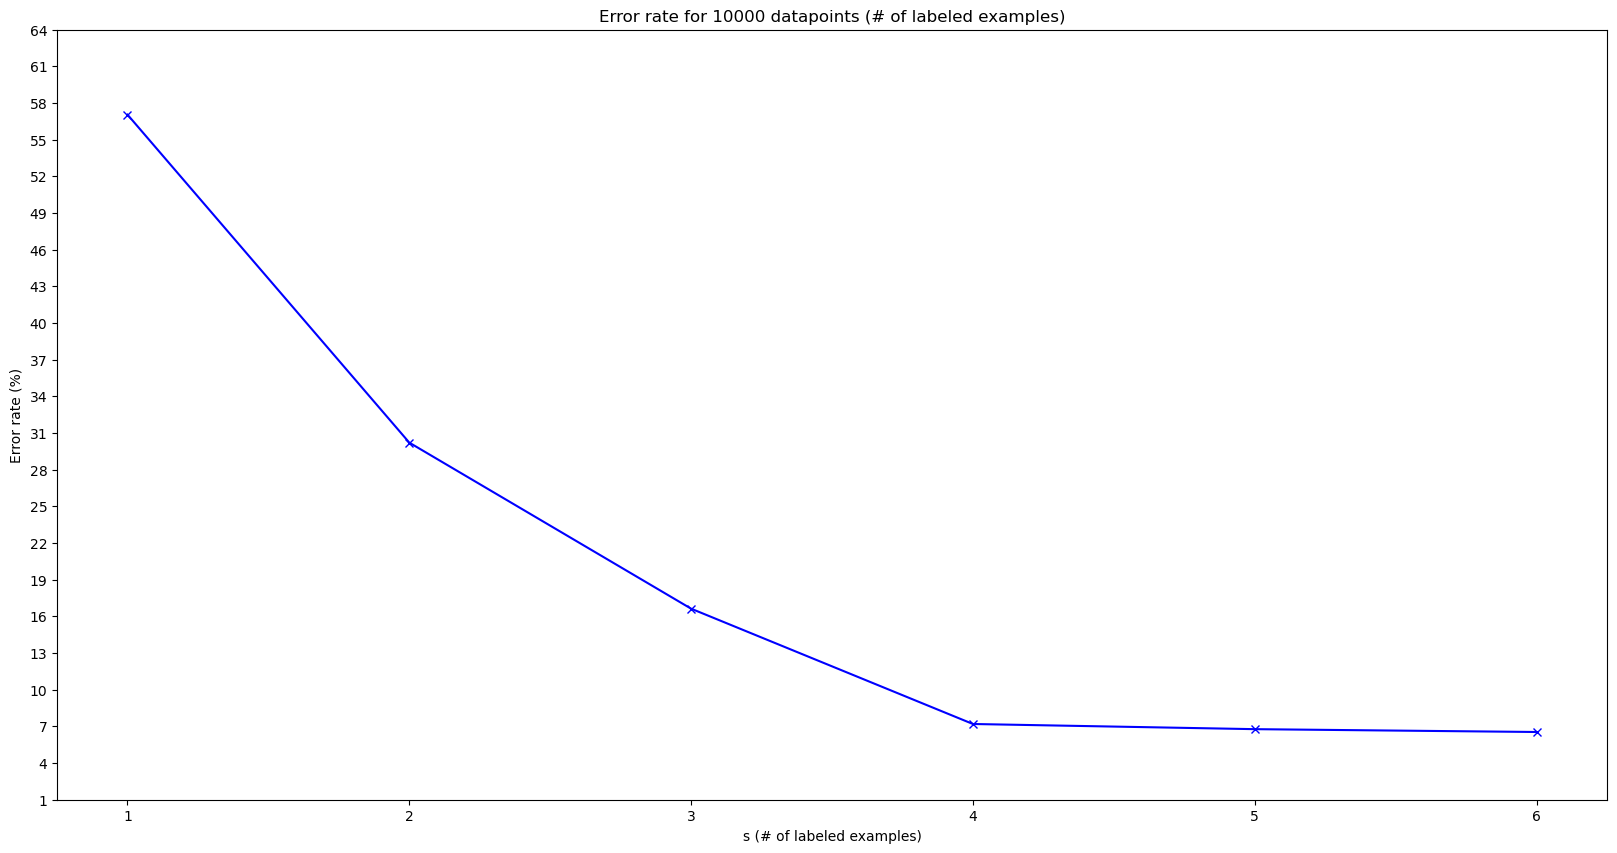

In [28]:
#plot specifications
# since the x axis distance is not relevant we use the code [1-20,2-50,3-100,4-500,5-1000,6-5000,7-20000]
#x=list(error60000_s.keys())
x=[1,2,3,4,5,6]

y=list(error10000_s.values())
plt.figure(figsize=(20, 10))
plt.plot(x, y,marker='x', color='b')
plt.xlabel('s (# of labeled examples)')  # Add an x-label to the axes.
plt.xticks([1,2,3,4,5,6])
plt.yticks(np.arange(1,66,3))
plt.ylabel('Error rate (%)')  # Add a y-label to the axes.
plt.title("Error rate for 10000 datapoints (# of labeled examples)")  # Add a title to the axes.

## 9. Results using 1,000 datapoints <a name="9"></a>

In [29]:
# n: number of datapoints to consider for manifold learning
n=1000

# construct dataset of size n
features_dataset, labels_dataset, not_needed = sample_label_points(n,image_features,labels)

# performing pca on the dataset
pca = PCA(n_components = 100)
pca_features = pca.fit_transform(features_dataset)

In [30]:
L=graph_laplacian(pca_features)

Procedure over 20 trials (since it is much faster for only 1000 datapoitns) for different values of $s$

In [31]:
trials=20
errors_trials=np.zeros((trials,1))
s_list=[20,50,100,500]
error1000_s={}

for s in s_list:

    for k in range(trials):
        
        print("Run:", k+1, "; s:",s)
        
        # i=s: number of labeled examples
        features_labeled_dataset, labels_labeled_dataset, index_list = sample_label_points(s,pca_features,labels_dataset)
        
        # p: number of eigenfunctions to keep
        p=round(s*0.2)
        
        # computes the lowest eigenvalues/eigenvectors of the Laplace operator
        evalues, efunctions=la.eigs(L,k=p,which='SM')
        
        E=E_matrix(efunctions,index_list,s,p)
        X=np.matmul(E.T,E)
        Y=np.linalg.inv(X)
        Z=np.matmul(Y,E.T)
        
        # compute the labels for unlabeled points
        confidence_levels = confidence_measure(efunctions,labels_labeled_dataset,n)
        final_labels = computing_labels(confidence_levels,n)
        
        # compute the error rate
        errors_trials[k]=error_rate(labels_dataset,final_labels)
        
    x=round(np.mean(errors_trials),3)
    print("s=",s,"error:",x,"%")
    error1000_s[s]=x

Run: 1 ; s: 20
Run: 2 ; s: 20
Run: 3 ; s: 20


C:\Users\telmo\AppData\Local\Temp\ipykernel_20336\2120893750.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i][j]=efunctions[index_list[i]][j]


Run: 4 ; s: 20
Run: 5 ; s: 20
Run: 6 ; s: 20
Run: 7 ; s: 20
Run: 8 ; s: 20
Run: 9 ; s: 20
Run: 10 ; s: 20
Run: 11 ; s: 20
Run: 12 ; s: 20
Run: 13 ; s: 20
Run: 14 ; s: 20
Run: 15 ; s: 20
Run: 16 ; s: 20
Run: 17 ; s: 20
Run: 18 ; s: 20
Run: 19 ; s: 20
Run: 20 ; s: 20
s= 20 error: 62.005 %
Run: 1 ; s: 50
Run: 2 ; s: 50
Run: 3 ; s: 50
Run: 4 ; s: 50
Run: 5 ; s: 50
Run: 6 ; s: 50
Run: 7 ; s: 50
Run: 8 ; s: 50
Run: 9 ; s: 50
Run: 10 ; s: 50
Run: 11 ; s: 50
Run: 12 ; s: 50
Run: 13 ; s: 50
Run: 14 ; s: 50
Run: 15 ; s: 50
Run: 16 ; s: 50
Run: 17 ; s: 50
Run: 18 ; s: 50
Run: 19 ; s: 50
Run: 20 ; s: 50
s= 50 error: 34.047 %
Run: 1 ; s: 100
Run: 2 ; s: 100
Run: 3 ; s: 100
Run: 4 ; s: 100
Run: 5 ; s: 100
Run: 6 ; s: 100
Run: 7 ; s: 100
Run: 8 ; s: 100
Run: 9 ; s: 100
Run: 10 ; s: 100
Run: 11 ; s: 100
Run: 12 ; s: 100
Run: 13 ; s: 100
Run: 14 ; s: 100
Run: 15 ; s: 100
Run: 16 ; s: 100
Run: 17 ; s: 100
Run: 18 ; s: 100
Run: 19 ; s: 100
Run: 20 ; s: 100
s= 100 error: 22.967 %
Run: 1 ; s: 500
Run: 2 ; 

Text(0.5, 1.0, 'Error rate for 1000 datapoints (# of labeled examples)')

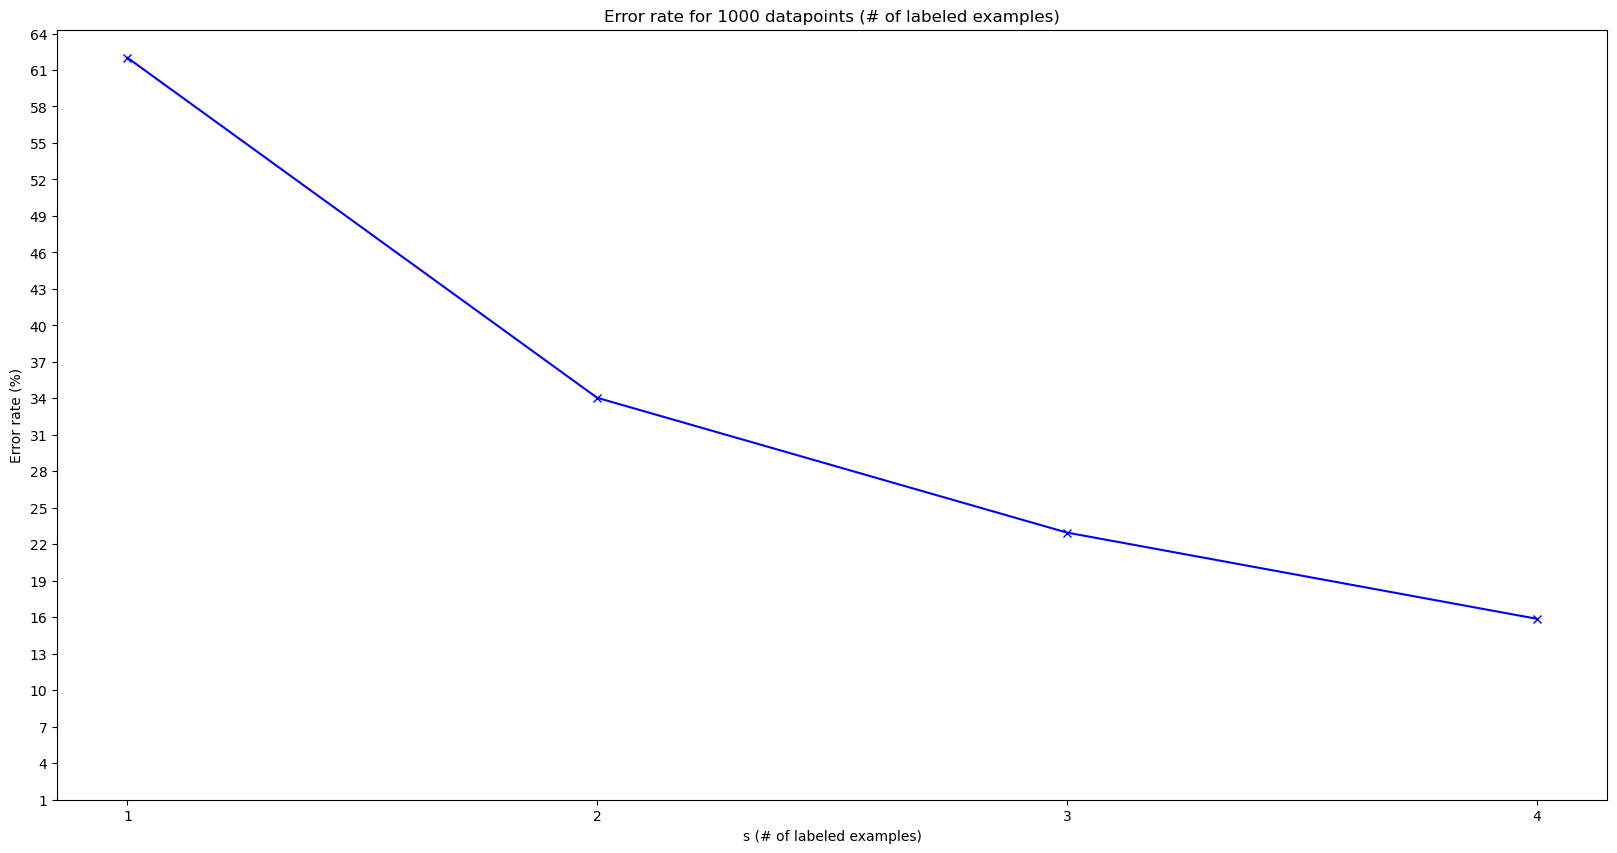

In [32]:
#plot specifications

# since the x axis distance is not relevant we use the code [1-20,2-50,3-100,4-500]
#x=list(error1000_s.keys())
x=[1,2,3,4]

y=list(error1000_s.values())
plt.figure(figsize=(20, 10))
plt.plot(x, y,marker='x', color='b')
plt.xlabel('s (# of labeled examples)')  # Add an x-label to the axes.
plt.xticks([1,2,3,4])
plt.yticks(np.arange(1,66,3))
plt.ylabel('Error rate (%)')  # Add a y-label to the axes.
plt.title("Error rate for 1000 datapoints (# of labeled examples)")  # Add a title to the axes.

## 10. Results using kNN <a name="10"></a>

In [33]:
from sklearn.neighbors import KNeighborsClassifier

image_features, labels = mnistdata.load_training()
pca = PCA(n_components = 100)
pca_features = pca.fit_transform(image_features)

# n: number of labeled examples
s=20
features_dataset, labels_dataset, index_list = sample_label_points(s,pca_features,labels)

neigh = KNeighborsClassifier(n_neighbors=3,p=2, metric='minkowski')
neigh.fit(features_dataset, labels_dataset)

KNeighborsClassifier(n_neighbors=3)

In [34]:
def knn_error_rate(index_list,pca_features,labels):
    
    error_count=0
    
    for i in range(len(labels)):
        
        if not(i in index_list):
            
            if(labels[i] != neigh.predict([pca_features[i]])):
                error_count+=1.0
                
    error_rate=error_count/(len(pca_features)-len(index_list))
    
    return error_rate

In [35]:
knn_error = knn_error_rate(index_list,pca_features,labels)
print("kNN error rate for s =",s,":", round(100*knn_error,3),"%")

kNN error rate for s = 20 : 66.616 %


In [36]:
#s_list=[20,50,100,500,1000,5000,20000]
#takes a long long time to run
s_list=[20,50,100,500,1000,5000]

knn_error_rate_dict={}

for s in s_list:
    
    features_dataset, labels_dataset, index_list = sample_label_points(s,pca_features,labels)
    
    neigh = KNeighborsClassifier(n_neighbors=3,p=2, metric='minkowski')
    neigh.fit(features_dataset, labels_dataset)
    
    knn_error = knn_error_rate(index_list,pca_features,labels)
    x=round(100*knn_error,3)
    print("kNN error rate for s =",s,":",x,"%")
    
    knn_error_rate_dict[s]=x

kNN error rate for s = 20 : 58.373 %
kNN error rate for s = 50 : 43.079 %
kNN error rate for s = 100 : 37.666 %


KeyboardInterrupt: 

## 11. Final Plot <a name="11"></a>

In [ ]:
#plot specifications

plt.figure(figsize=(20,10))


x=[1,2,3,4,5,6]
y=list(error60000_s.values())

plt.plot(x, y,marker='x', color='b', label = "60,000 datapoints")

plt.xlabel('Number of labeled datapoints')  
plt.xticks([1,2,3,4,5,6])
plt.yticks(np.arange(1,66,3))
plt.ylabel('Error rate (%)')  

x=[1,2,3,4,5,6]
y=list(error10000_s.values())
plt.plot(x, y,marker='o', color='r', label = "10,000 datapoints")

x=[1,2,3,4]
y=list(error1000_s.values())
plt.plot(x, y,marker='^', color='g', label = "1000 datapoints")

x=[1,2,3,4,5,6]
y=list(knn_error_rate_dict.values())
plt.plot(x, y, marker='+',linestyle='dashed', color='black', label = "kNN (k=3)")

plt.legend()